In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch

In [2]:
from pts.dataset import to_pandas, MultivariateGrouper, TrainDatasets
from pts.dataset.repository import get_dataset, dataset_recipes
from pts.model.tempflow import TempFlowEstimator
from pts.model.time_grad import TimeGradEstimator
from pts.model.transformer_tempflow import TransformerTempFlowEstimator
from pts import Trainer
from pts.evaluation import make_evaluation_predictions
from pts.evaluation import MultivariateEvaluator

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def plot(target, forecast, prediction_length, prediction_intervals=(50.0, 90.0), color='g', fname=None):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape
    
    ps = [50.0] + [
            50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
        ]
        
    percentiles_sorted = sorted(set(ps))
    
    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3
        
    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)
        
        ps_data = [forecast.quantile(p / 100.0)[:,dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2
        
        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)
        
        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]    
    axx[0].legend(legend, loc="upper left")
    
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.05)

## Prepeare data set

In [5]:
dataset = get_dataset("solar_nips", regenerate=False, shuffle=False)

In [6]:
dataset.metadata

MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat', cardinality='137')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)

In [7]:
train_grouper = MultivariateGrouper(max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality))

test_grouper = MultivariateGrouper(num_test_dates=int(len(dataset.test)/len(dataset.train)), 
                                   max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality))

In [8]:
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

/mnt/scratch/kashif/pytorch-ts/pts/dataset/multivariate_grouper.py:175: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return {FieldName.TARGET: np.array([funcs(data) for data in dataset])}


## Evaluator

In [9]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:],
                                  target_agg_funcs={'sum': np.sum})

## `Time-Grad`

In [11]:
estimator = TimeGradEstimator(
    target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length,
    cell_type='GRU',
    input_size=552,
    freq=dataset.metadata.freq,
    scaling=True,
    trainer=Trainer(device=device,
                    epochs=10,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100,
                    batch_size=64,
                    num_workers=8)
)

In [12]:
predictor = estimator.train(dataset_train)

99it [00:11,  8.37it/s, avg_epoch_loss=0.791, epoch=0]
99it [00:10,  9.03it/s, avg_epoch_loss=0.774, epoch=1]
99it [00:10,  9.12it/s, avg_epoch_loss=0.765, epoch=2]
99it [00:10,  9.18it/s, avg_epoch_loss=0.759, epoch=3]
99it [00:11,  8.99it/s, avg_epoch_loss=0.755, epoch=4]
99it [00:11,  8.92it/s, avg_epoch_loss=0.752, epoch=5]
99it [00:11,  8.83it/s, avg_epoch_loss=0.75, epoch=6]
99it [00:11,  8.80it/s, avg_epoch_loss=0.748, epoch=7]
99it [00:11,  8.72it/s, avg_epoch_loss=0.746, epoch=8]
99it [00:11,  8.88it/s, avg_epoch_loss=0.745, epoch=9]


In [13]:
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                             predictor=predictor,
                                             num_samples=100)

In [14]:
forecasts = list(forecast_it)
targets = list(ts_it)

In [15]:
agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))

Running evaluation: 7it [00:00, 19.17it/s]
Running evaluation: 7it [00:00, 19.79it/s]
Running evaluation: 7it [00:00, 19.76it/s]
Running evaluation: 7it [00:00, 19.79it/s]
Running evaluation: 7it [00:00, 19.83it/s]
Running evaluation: 7it [00:00, 19.88it/s]
Running evaluation: 7it [00:00, 19.46it/s]
Running evaluation: 7it [00:00, 20.22it/s]
Running evaluation: 7it [00:00, 19.92it/s]
Running evaluation: 7it [00:00, 19.51it/s]
Running evaluation: 7it [00:00, 19.62it/s]
Running evaluation: 7it [00:00, 19.62it/s]
Running evaluation: 7it [00:00, 20.29it/s]
Running evaluation: 7it [00:00, 19.43it/s]
Running evaluation: 7it [00:00, 19.84it/s]
Running evaluation: 7it [00:00, 19.19it/s]
Running evaluation: 7it [00:00, 19.87it/s]
Running evaluation: 7it [00:00, 20.04it/s]
Running evaluation: 7it [00:00, 19.75it/s]
Running evaluation: 7it [00:00, 19.30it/s]
Running evaluation: 7it [00:00, 19.63it/s]
Running evaluation: 7it [00:00, 19.63it/s]
Running evaluation: 7it [00:00, 20.17it/s]
Running eva

### Metrics

In [16]:
print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

CRPS: 1.0254185898558072
ND: 1.1104788819840408
NRMSE: 2.0375093361893195
MSE: 3938.011701425414


In [29]:
print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

CRPS: 0.42624134391621216
ND: 0.581665257675843
NRMSE: 1.1427574708800348
MSE: 1238.7564415711265


In [17]:
print("CRPS-Sum: {}".format(agg_metric['m_sum_mean_wQuantileLoss']))
print("ND-Sum: {}".format(agg_metric['m_sum_ND']))
print("NRMSE-Sum: {}".format(agg_metric['m_sum_NRMSE']))
print("MSE-Sum: {}".format(agg_metric['m_sum_MSE']))
print("ES: {}".format(agg_metric['m_ES']))

CRPS-Sum: 1.0131539578430029
ND-Sum: 1.0416689340092466
NRMSE-Sum: 1.825863533244651
MSE-Sum: 59354762.666666664


KeyError: 'm_ES'

In [30]:
print("CRPS-Sum: {}".format(agg_metric['m_sum_mean_wQuantileLoss']))
print("ND-Sum: {}".format(agg_metric['m_sum_ND']))
print("NRMSE-Sum: {}".format(agg_metric['m_sum_NRMSE']))
print("MSE-Sum: {}".format(agg_metric['m_sum_MSE']))
print("ES: {}".format(agg_metric['m_ES']))

CRPS-Sum: 0.3976591363179181
ND-Sum: 0.5400319562913917
NRMSE-Sum: 0.959254707073696
MSE-Sum: 16382750.642857144
ES: 173.12250082833427


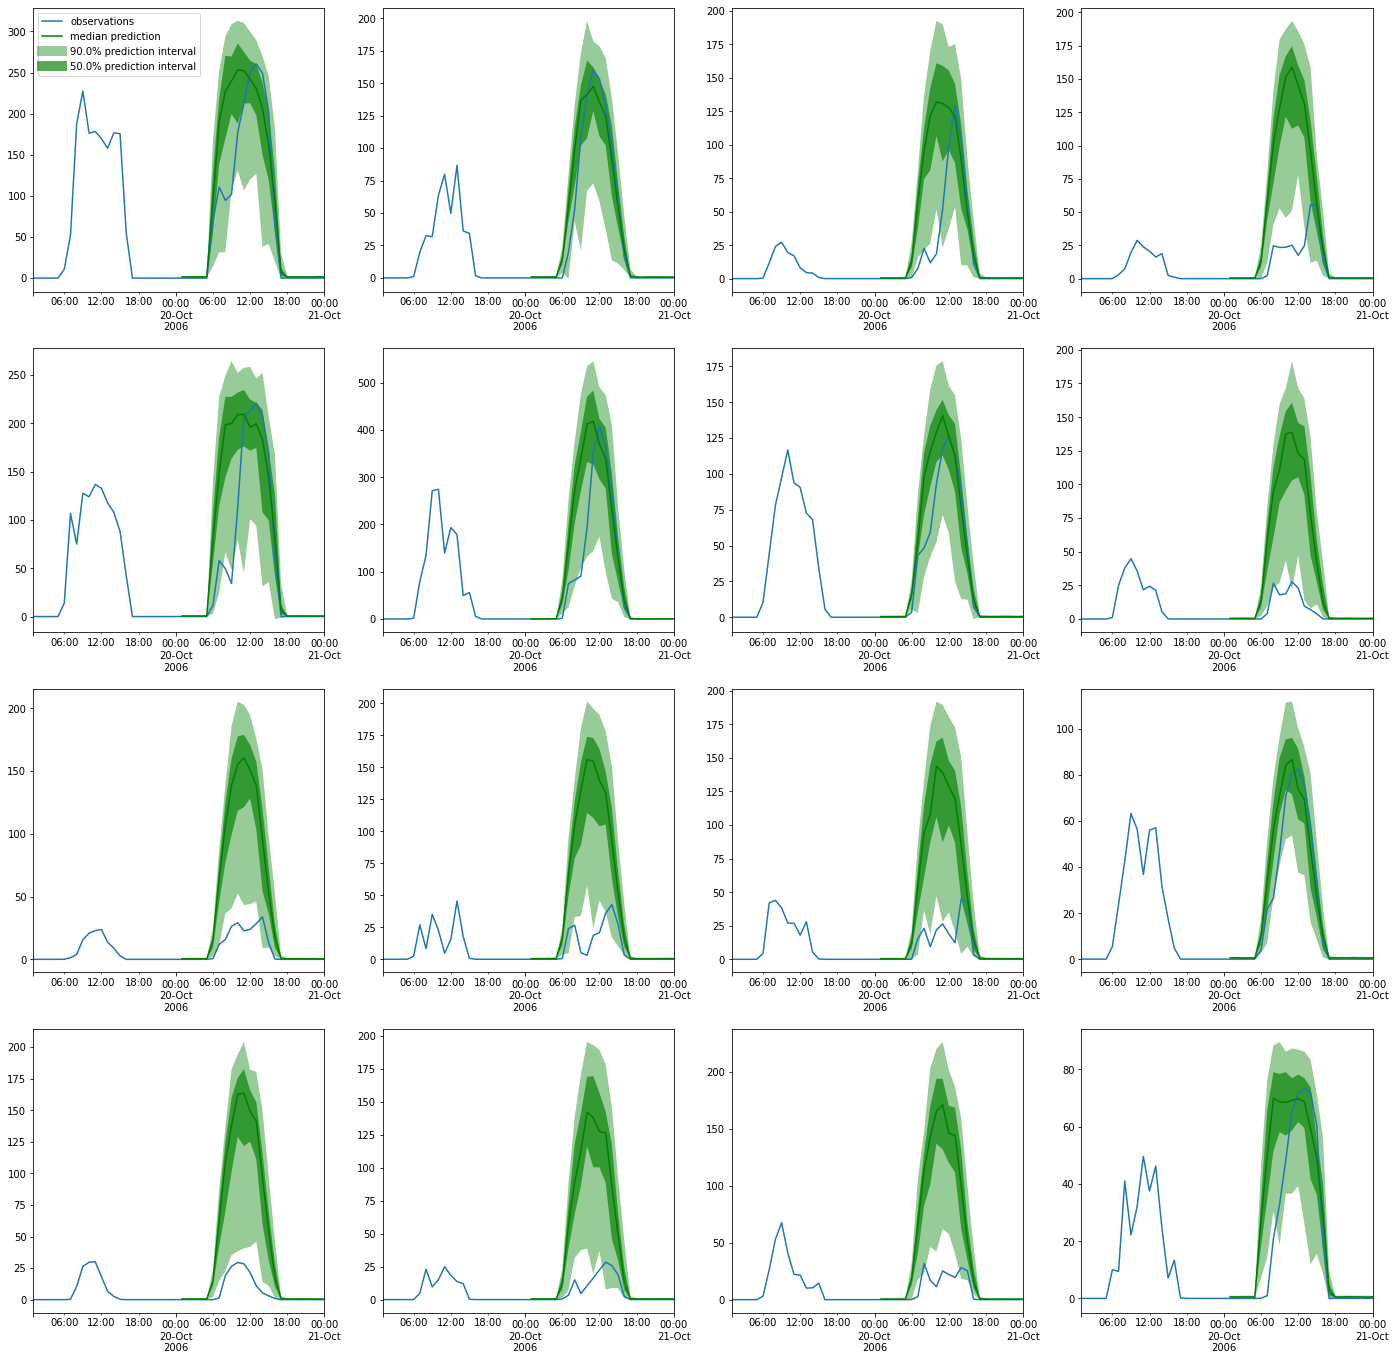

In [31]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=dataset.metadata.prediction_length,
)

## `GRU-MAF`

In [32]:
estimator = TempFlowEstimator(
    target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
    prediction_length=dataset.metadata.prediction_length,
    cell_type='GRU',
    input_size=552,
    freq=dataset.metadata.freq,
    scaling=True,
    dequantize=True,
    flow_type='MAF',
    trainer=Trainer(device=device,
                    epochs=25,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100,
                    batch_size=128,
                   num_workers=8,)
)

In [37]:
predictor = estimator.train(dataset_train)
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                             predictor=predictor,
                                             num_samples=200)
forecasts = list(forecast_it)
targets = list(ts_it)

agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))

Running evaluation: 7it [00:00, 18.14it/s]
Running evaluation: 7it [00:00, 18.19it/s]
Running evaluation: 7it [00:00, 18.49it/s]
Running evaluation: 7it [00:00, 18.25it/s]
Running evaluation: 7it [00:00, 18.61it/s]
Running evaluation: 7it [00:00, 18.08it/s]
Running evaluation: 7it [00:00, 18.87it/s]
Running evaluation: 7it [00:00, 18.21it/s]
Running evaluation: 7it [00:00, 18.48it/s]
Running evaluation: 7it [00:00, 18.50it/s]
Running evaluation: 7it [00:00, 18.16it/s]
Running evaluation: 7it [00:00, 19.12it/s]
Running evaluation: 7it [00:00, 18.76it/s]
Running evaluation: 7it [00:00, 18.71it/s]
Running evaluation: 7it [00:00, 18.45it/s]
Running evaluation: 7it [00:00, 18.01it/s]
Running evaluation: 7it [00:00, 18.10it/s]
Running evaluation: 7it [00:00, 18.60it/s]
Running evaluation: 7it [00:00, 17.84it/s]
Running evaluation: 7it [00:00, 18.44it/s]
Running evaluation: 7it [00:00, 18.62it/s]
Running evaluation: 7it [00:00, 18.55it/s]
Running evaluation: 7it [00:00, 18.59it/s]
Running eva

### Metrics

In [38]:
print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

CRPS: 0.4044600877754162
ND: 0.5249931713866037
NRMSE: 1.1289207500593752
MSE: 1208.9398648418153


In [39]:
print("CRPS-Sum: {}".format(agg_metric['m_sum_mean_wQuantileLoss']))
print("ND-Sum: {}".format(agg_metric['m_sum_ND']))
print("NRMSE-Sum: {}".format(agg_metric['m_sum_NRMSE']))
print("MSE-Sum: {}".format(agg_metric['m_sum_MSE']))
print("ES: {}".format(agg_metric['m_ES']))

CRPS-Sum: 0.3486330770610822
ND-Sum: 0.4400007977004845
NRMSE-Sum: 0.772876113478807
MSE-Sum: 10635029.857142856
ES: 170.7280044555664


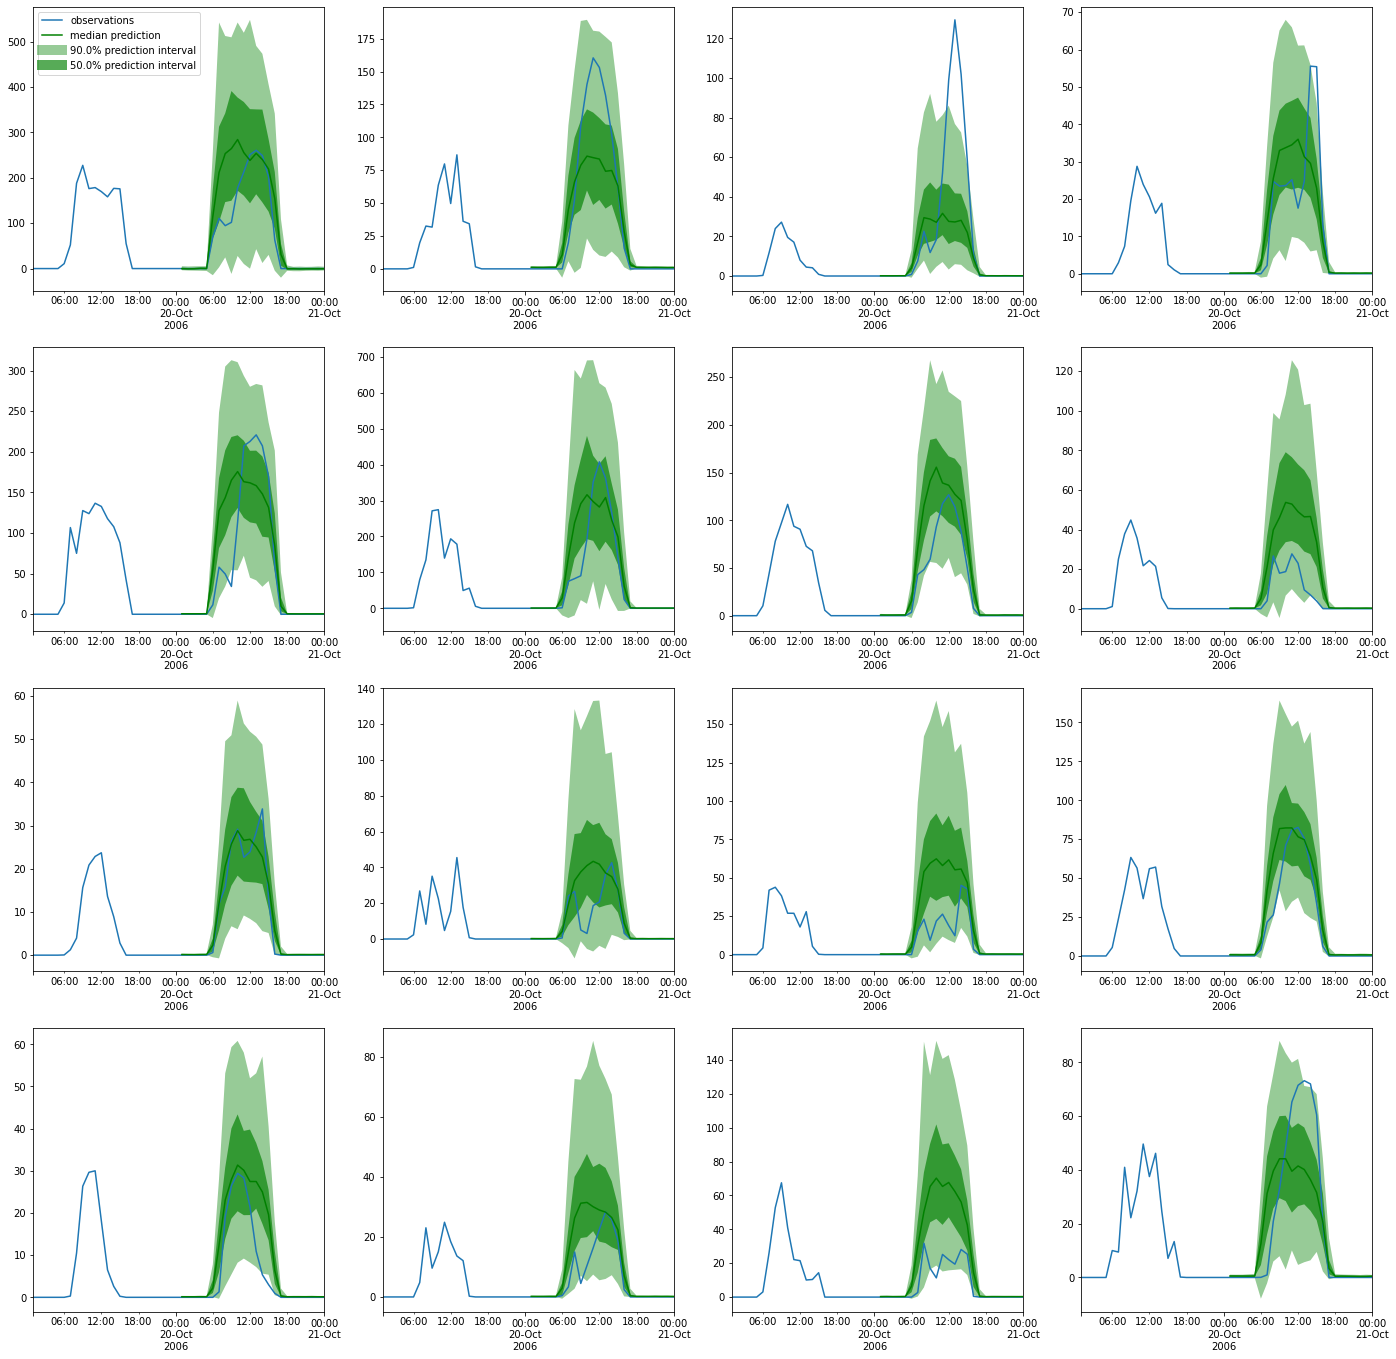

In [40]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=dataset.metadata.prediction_length,
)

## `Transformer-MAF`

In [41]:
estimator = TransformerTempFlowEstimator(
    d_model=16,
    num_heads=4,
    input_size=552,
    target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*4,
    flow_type='MAF',
    dequantize=True,
    freq=dataset.metadata.freq,
    trainer=Trainer(
        device=device,
        epochs=14,
        learning_rate=1e-3,
        num_batches_per_epoch=100,
        batch_size=64,
    )
)

In [42]:
predictor = estimator.train(dataset_train)
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                             predictor=predictor,
                                             num_samples=100)
forecasts = list(forecast_it)
targets = list(ts_it)

agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))

99it [00:11,  8.71it/s, avg_epoch_loss=-35.8, epoch=0]
99it [00:11,  8.76it/s, avg_epoch_loss=-160, epoch=1]
99it [00:11,  8.70it/s, avg_epoch_loss=-179, epoch=2]
99it [00:11,  8.54it/s, avg_epoch_loss=-192, epoch=3]
99it [00:11,  8.55it/s, avg_epoch_loss=-200, epoch=4]
99it [00:11,  8.68it/s, avg_epoch_loss=-206, epoch=5]
99it [00:11,  8.78it/s, avg_epoch_loss=-211, epoch=6]
99it [00:11,  8.71it/s, avg_epoch_loss=-214, epoch=7]
99it [00:11,  8.74it/s, avg_epoch_loss=-217, epoch=8]
99it [00:11,  8.72it/s, avg_epoch_loss=-219, epoch=9]
99it [00:11,  8.74it/s, avg_epoch_loss=-221, epoch=10]
99it [00:11,  8.77it/s, avg_epoch_loss=-222, epoch=11]
99it [00:11,  8.76it/s, avg_epoch_loss=-224, epoch=12]
99it [00:11,  8.74it/s, avg_epoch_loss=-225, epoch=13]
Running evaluation: 7it [00:00, 19.13it/s]
Running evaluation: 7it [00:00, 19.54it/s]
Running evaluation: 7it [00:00, 18.82it/s]
Running evaluation: 7it [00:00, 19.19it/s]
Running evaluation: 7it [00:00, 19.02it/s]
Running evaluation: 7it 

### Metrics

In [43]:
print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

CRPS: 0.38470005451400363
ND: 0.5214878896693099
NRMSE: 1.0084791236300625
MSE: 964.742946883975


In [44]:
print("CRPS-Sum: {}".format(agg_metric['m_sum_mean_wQuantileLoss']))
print("ND-Sum: {}".format(agg_metric['m_sum_ND']))
print("NRMSE-Sum: {}".format(agg_metric['m_sum_NRMSE']))
print("MSE-Sum: {}".format(agg_metric['m_sum_MSE']))
print("ES: {}".format(agg_metric['m_ES']))

CRPS-Sum: 0.3210175044603147
ND-Sum: 0.43597371073243457
NRMSE-Sum: 0.772647695448834
MSE-Sum: 10628744.57142857
ES: 160.438353402274


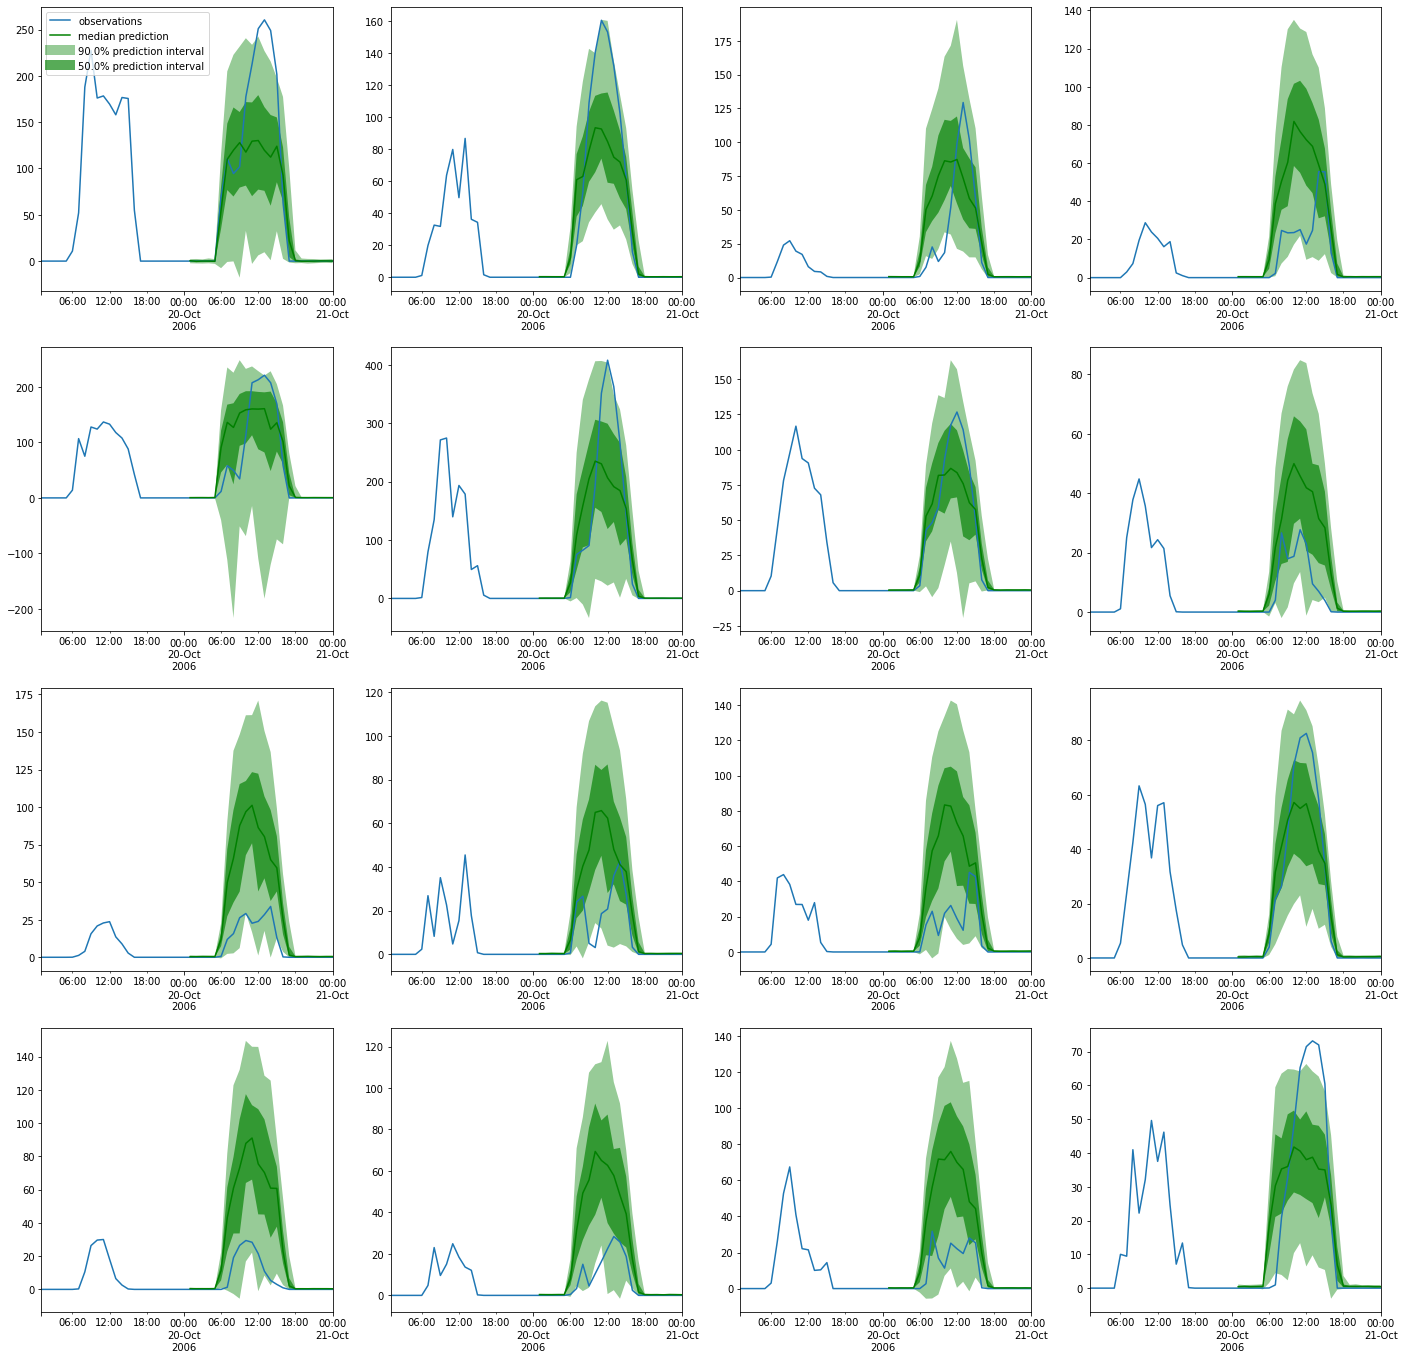

In [45]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=dataset.metadata.prediction_length,
)